In [65]:
# General
import pickle
import pandas as pd
import numpy as np
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# SARIMAX
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm


# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)



In [ ]:
# Load data, sort on zip and date and set index to datetime
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f:
    data = pickle.load(f)
data.sort_values(['census_cbsa_geoid', 'census_zcta5_geoid', 'date'])
data.set_index('date', inplace=True)

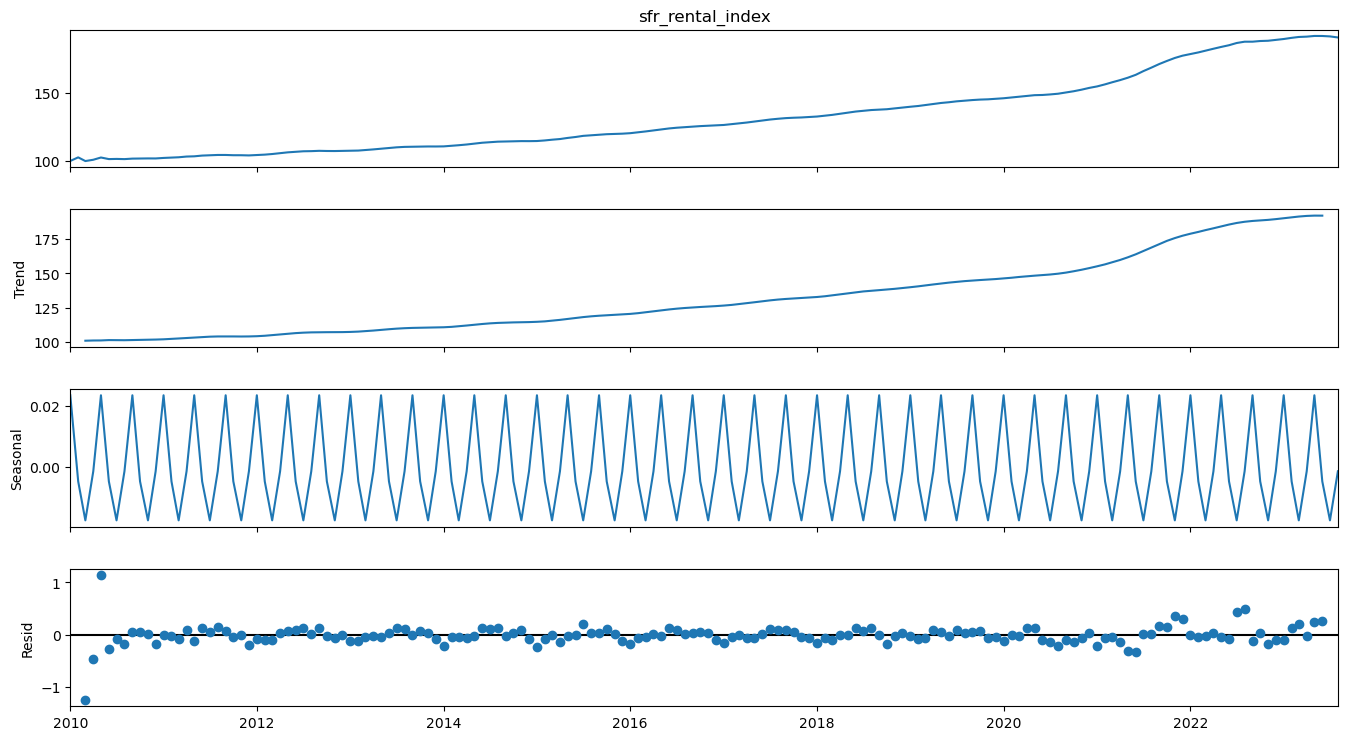

In [5]:
df_sub = data[data['census_zcta5_geoid'] == '30002']

res = sm.tsa.seasonal_decompose(df_sub['sfr_rental_index'].dropna(), period = 4) # by monthly

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [6]:
#train_test_split
tr_start,tr_end = '2010-01-01','2022-07-01'
te_start,te_end = '2022-08-01','2023-08-01'
tra = df_sub['sfr_rental_index'][tr_start:tr_end].dropna()
tes = df_sub['sfr_rental_index'][te_start:te_end].dropna()

In [31]:
# Check stationarity (not stationary)
#Time series are stationary if they do not have trend or seasonal effects. 
# Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

#ADF-test(Original-time-series)
# If we fail to reject null hypothesis (Null Hypothesis (H0): alpha=1), the time series is non-stationary - this is rather obvious from the plots above
res = sm.tsa.adfuller(df_sub['sfr_rental_index'].dropna(),regression='ctt')
print('p-value:{}'.format(res[1]))

#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(df_sub['sfr_rental_index'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

# NEITHER THE RAW DATA OR THE DIFFERENCE DATA ARE STATIONARY

p-value:0.07565621335547626
p-value:0.12493424154434923


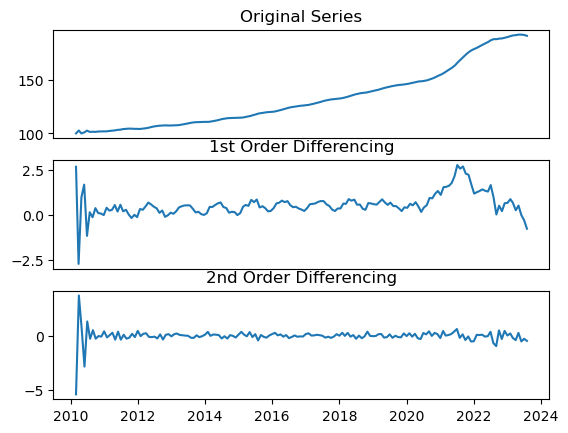

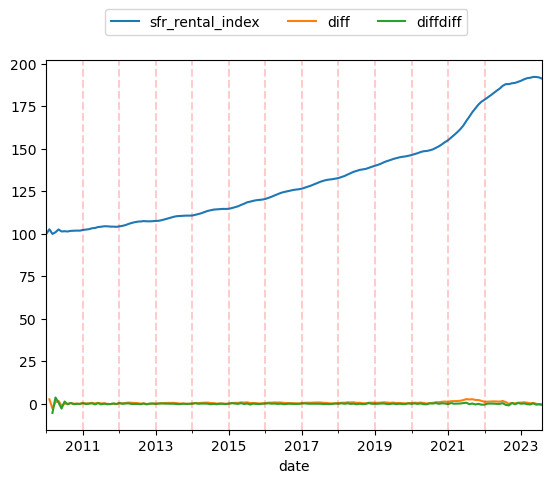

In [51]:
# Finding the appropriate order of differencing (d parameter in ARIMA). 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_sub.sfr_rental_index); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_sub.sfr_rental_index.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_sub.sfr_rental_index.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

# Here 1st order differencing seems to be the best as the trend is mostly removed and the time series appears stationary
# 2nd order differencing is probably over differencing but we will confirm with autocorrelation plots below

# ALSO to see how trend is removed and data become stationary
#acf -> remove trend 
df_sub["diff"] = df_sub['sfr_rental_index'].diff()
df_sub['diffdiff'] = df_sub['sfr_rental_index'].diff().diff()
tmp = df_sub[['sfr_rental_index', 'diff', 'diffdiff']]
ax = tmp.plot()
ax.legend(ncol=5, 
          loc='upper center',
          bbox_to_anchor=(0.5, 1.0),
          bbox_transform=plt.gcf().transFigure)
for yr in range(2010, 2023):
    ax.axvline(pd.to_datetime(str(yr)+"-01-01"), color ="red", linestyle = "--", alpha = 0.2)

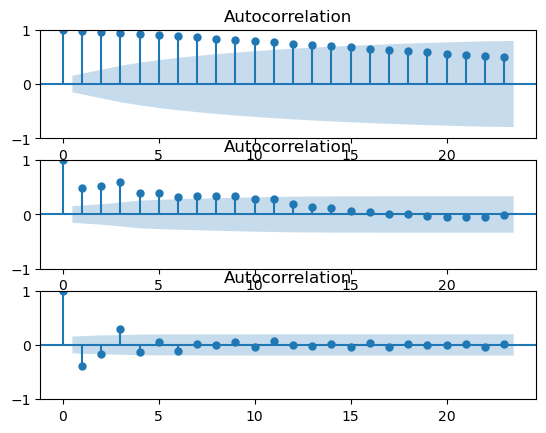

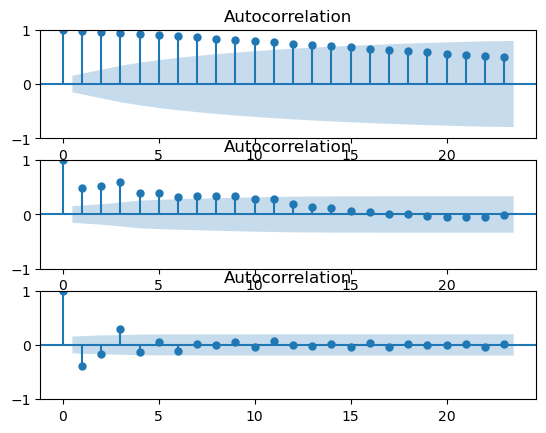

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_sub.sfr_rental_index, ax=ax1)
plot_acf(df_sub.sfr_rental_index.diff().dropna(), ax=ax2)
plot_acf(df_sub.sfr_rental_index.diff().diff().dropna(), ax=ax3)

# Final decision: 1st order differencing

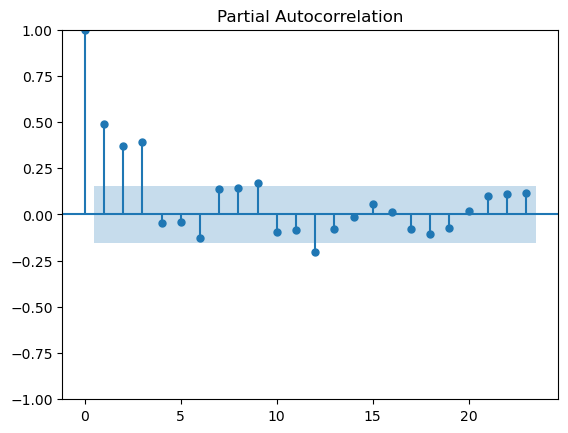

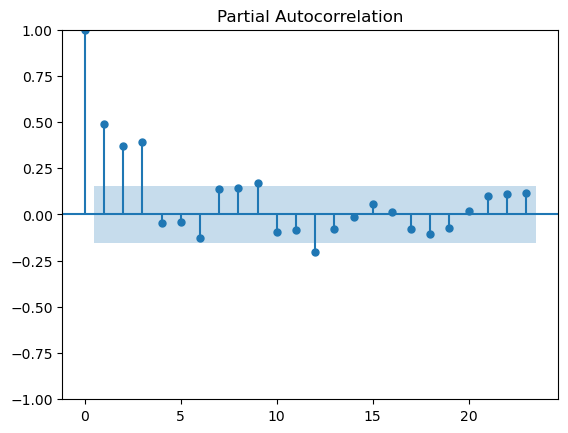

In [53]:
#The partial autocorrelation function plot can be used to draw a correlation 
# between the time series and its lag while the contribution from intermediate lags can be ignored.
# Significant correlation in a stationary time series can be represented by adding auto regression terms. 
# Using the PACF plot we can take the order of AR terms to be equal to the lags that can cross a significance limit. 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_sub.sfr_rental_index.diff().dropna())

# Select order of p = 3 (3 significant lags)

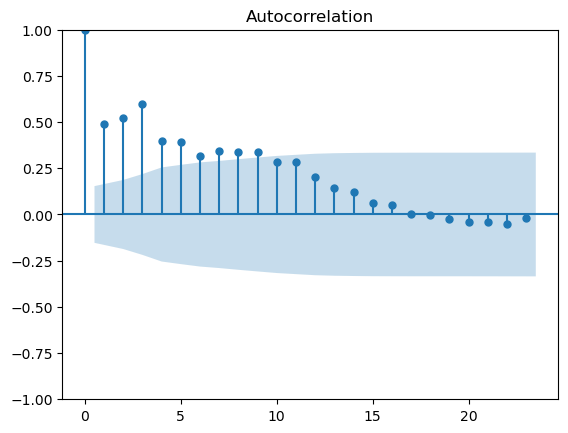

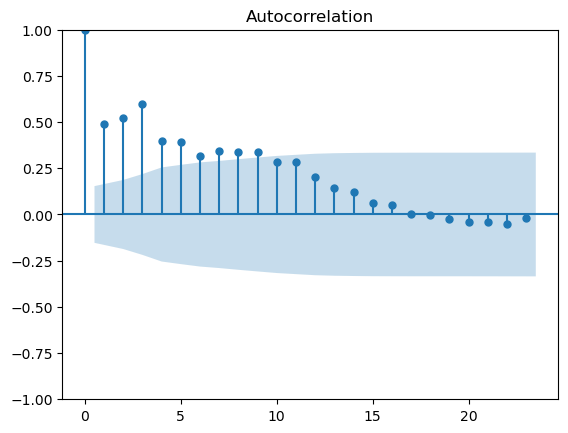

In [54]:
# Determine q parameter (the size of the moving average window required to remove autocorrelation)
plot_acf(df_sub.sfr_rental_index.diff().dropna())

# q = 6

In [55]:
# Estimate the best value for P parameter - the number of autoregressive terms
resDiff = sm.tsa.arma_order_select_ic(df_sub['sfr_price_index'].diff(), max_ar=4, max_ma=6, ic='aic', trend='c')


/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/py

In [56]:
#p is the number of autoregressive terms, (3)
#d is the number of nonseasonal differences, (1)
#q is the number of lagged forecast errors in the prediction equation (5)

print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (3, 5) is the best.


In [75]:

arima = sm.tsa.statespace.SARIMAX(df_sub['sfr_rental_index'],
                                  order=(3,1,5), 
                                  seasonal_order=(0,0,0,0),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20989D-02    |proj g|=  6.25340D-01

At iterate    5    f= -3.68386D-02    |proj g|=  4.79659D-01

At iterate   10    f= -5.50692D-02    |proj g|=  7.64813D-02

At iterate   15    f= -6.59202D-02    |proj g|=  6.52586D-01

At iterate   20    f= -1.00787D-01    |proj g|=  9.32156D-02

At iterate   25    f= -1.12792D-01    |proj g|=  4.26675D-02

At iterate   30    f= -1.30726D-01    |proj g|=  9.25593D-02

At iterate   35    f= -1.33555D-01    |proj g|=  8.04132D-03

At iterate   40    f= -1.33565D-01    |proj g|=  1.02159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       sfr_rental_index   No. Observations:                  164
Model:               SARIMAX(3, 1, 5)   Log Likelihood                  21.905
Date:                Wed, 04 Oct 2023   AIC                            -25.809
Time:                        11:54:31   BIC                              1.697
Sample:                    01-01-2010   HQIC                           -14.638
                         - 08-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2361      0.081      2.926      0.003       0.078       0.394
ar.L2          0.3436      0.053      6.471      0.000       0.240       0.448
ar.L3          0.0426      0.058      0.741      0.459      -0.070       0.155
ma.L1          0.8361      0.081     10.371      0.000       0.678       0.994
ma.L2          0.6866      0.093      7.382      0.000       0.504       0.869
ma.L3          0.7583      0.060     12.681      0.000       0.641       0.876
ma.L4          0.7396      0.072     10.230      0.000       0.598       0.881
ma.L5          0.7433      0.069     10.734      0.000       0.608       0.879
sigma2         0.0432      0.004     10.624      0.000       0.035       0.051
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):                21.01
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               3.22   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notes on warning: Covariance matrix culculated using the outer product of gradients (complex-step).

- This warning is actually more like a "note" than a "warning". It's just letting you know how the covariance matrix was computed.

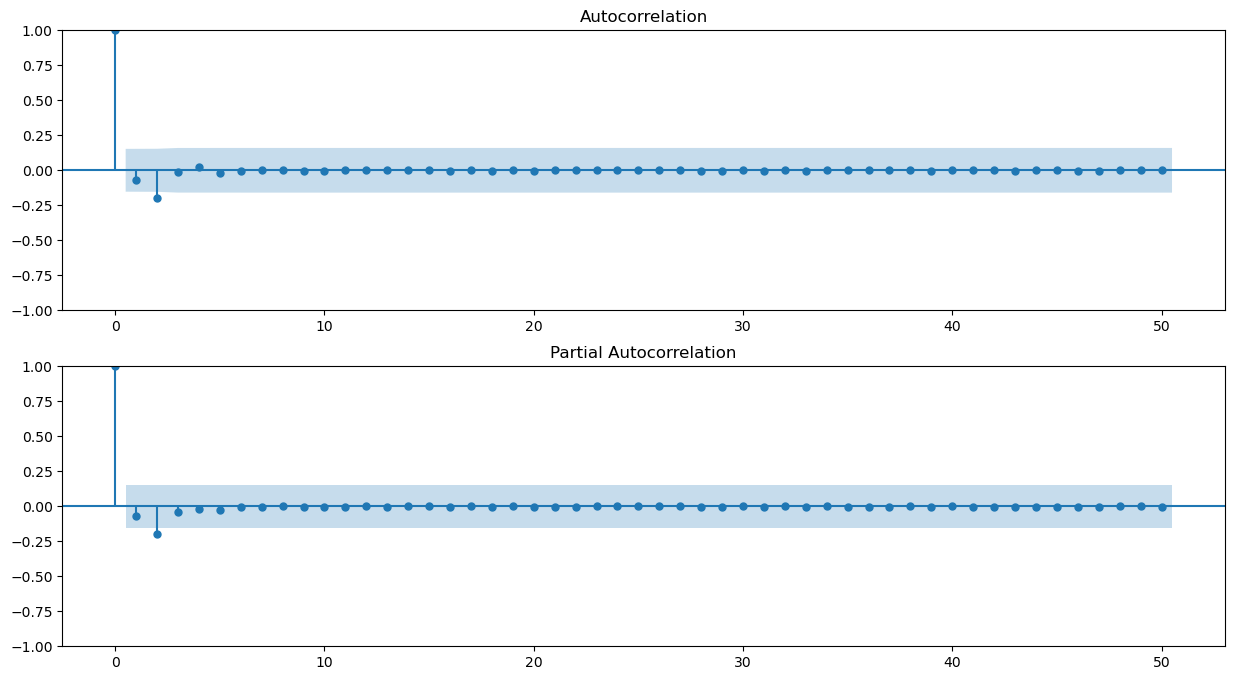

In [70]:


# Check model autocorrelation
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMA model MSE:0.15312734357663116


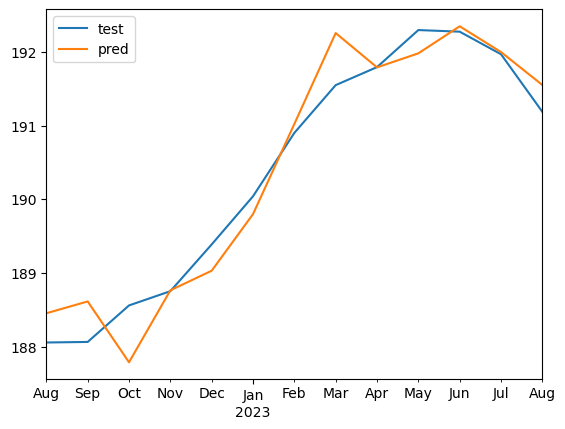

In [77]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()
